# Cooperative Kernel regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## **Partie 1 :** 

Solvers pour les différentes méthodes (on a choisi de faire de la POO)

In [189]:
def kernel(x,y):
    return np.exp(-(x-y)**2)

def compute_doubly_stochastic_matrix(adjacence_matrix):
    n,p = np.shape(adjacence_matrix)
    doubly_stochastic_matrix = np.copy(adjacence_matrix)
    max_sum = np.max(np.array([np.sum(adjacence_matrix[i]) for i in range(n)]))
    for i in range(n):
        doubly_stochastic_matrix[i,i] = max_sum -(np.sum(adjacence_matrix[i])-1)
    return(doubly_stochastic_matrix/max_sum)


class instance:
    def __init__(self,X,centers_kernel,Y,kernel_center_of_agent,data_point_of_agent,communication_matrix,sigma) -> None:
        self.centers_kernel=centers_kernel
        self.X = X
        self.Y=Y
        self.kernel_center_of_agent = kernel_center_of_agent
        self.data_point_of_agent = data_point_of_agent
        self.communication_matrix = communication_matrix
        self.sigma = sigma
        number_of_kernels = np.shape(centers_kernel)[0]
        number_of_datas = np.shape(X)[0]
        self.number_of_datas = number_of_datas
        self.number_of_kernels = number_of_kernels
        self.Kmm_matrix = np.array([[kernel(centers_kernel[k],centers_kernel[l]) for k in range(number_of_kernels)]for l in range(number_of_kernels)])
        self.Knm_matrix = np.array([[kernel(centers_kernel[k],X[l]) for k in range(number_of_kernels)]for l in range(self.number_of_datas)])
        number_of_agents,kernels_per_agent = np.shape(kernel_center_of_agent)
        _,data_per_agent = np.shape(data_point_of_agent)
        self.number_of_agents = number_of_agents
        self.kernels_per_agent = kernels_per_agent
        self.data_per_agent = data_per_agent
        matrixA = np.identity(number_of_agents*number_of_kernels)
        for index in range(number_of_kernels):
                matrixA[(number_of_agents-1)*number_of_kernels+index,(number_of_agents-1)*number_of_kernels+index]=0
        for index in range((number_of_agents-1)*number_of_kernels):
                matrixA[index,index+number_of_kernels]=-1
        self.matrixA = matrixA
        self.true_solution = np.zeros(number_of_agents)

    def objective(self,curent_solution):
        objecti = np.dot(curent_solution,np.dot(self.Kmm_matrix,curent_solution))/2
        for agent_index in range(self.number_of_agents):
            for agent_index_2 in range(self.data_per_agent):
                matrix_Kim = np.array([kernel(self.X[self.data_point_of_agent[agent_index,agent_index_2]],self.centers_kernel[j]) for j in range(self.number_of_kernels)])
                objecti+=(1/(2*(self.sigma**2)))*(self.Y[self.data_point_of_agent[agent_index,agent_index_2]]-np.dot(matrix_Kim,curent_solution))**2
        return(objecti)
    
    def gradient(self,agent_index,point):
        sum  = np.dot(self.Kmm_matrix,point)/5    
        for agent_index_2 in range(self.data_per_agent):
            matrix_Kim = np.array([kernel(self.X[self.data_point_of_agent[agent_index,agent_index_2]],self.centers_kernel[j]) for j in range(self.number_of_kernels)])
            sum -=matrix_Kim*(self.Y[self.data_point_of_agent[agent_index,agent_index_2]]-np.dot(matrix_Kim,point))/(self.sigma**2)
        return sum
    
    def complete_gradient(self,point):
        product = np.dot(self.Knm_matrix.T,self.Knm_matrix) 
        grad = np.dot(self.Kmm_matrix+(1/self.sigma**2)*product,point)
        grad -= (1/self.sigma**2)*np.dot(self.Y.T,self.Knm_matrix)
        return(grad)
    



class solver : 

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        self.instance = instance1
        self.step_size = step_size
        self.number_iteration = number_iteration
        self.initialisation = initialisation
        self.variable_zize = np.shape(initialisation)[0]

class gradient_descent(solver):
    def __init__(self, instance1, step_size, number_iteration, initialisation) -> None:
        super().__init__(instance1, step_size, number_iteration, initialisation)
        self.curent_solution = initialisation
        self.new_solution = initialisation

    def solve(self,verbose = True):
        for iteration in range(self.number_iteration):
            self.do_gradient_descent_step()
            self.curent_solution = self.new_solution
            if verbose:
                self.display_objective()
        return(self.curent_solution)

    def do_gradient_descent_step(self):    
        gradient = self.instance.complete_gradient(self.curent_solution)
        self.new_solution = self.curent_solution - self.step_size*gradient
    
    def display_objective(self):
        print("Objective : "+str(self.instance.objective(self.curent_solution)))


class DGD(solver):
    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))
        self.original_communication_matrix = compute_doubly_stochastic_matrix(self.instance.communication_matrix)
        self.effective_communication_matrix = compute_doubly_stochastic_matrix(self.instance.communication_matrix)


    def solve(self,verbose = True, package_loss = False,probability_package_loss = 0):
        for iteration in range(self.number_iteration):
            if verbose:
                print("Iterration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)

            self.do_optimisation_step_DGD(verbose,package_loss,probability_package_loss)

            if package_loss:
                self.reinitialize_communication_matrix()

            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)
    
    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)
    
    def do_optimisation_step_DGD(self,verbose = True,package_loss = False,probability_package_loss = 0):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        
        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index,verbose)
    
        if verbose : 
            self.display_objective()
        self.curent_solution = self.new_solution

    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = compute_doubly_stochastic_matrix(sampled_adjacence_matrix)

    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def do_local_gradient_descent(self,agent_index,verbose=True):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        if verbose : 
            print("Agent " + str(agent_index)+" norme du gradient : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.effective_communication_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))


class gradient_tracking(DGD):

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])
        self.new_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])
    
    def reinitialize_communication_matrix(self):
        return super().reinitialize_communication_matrix()
    
    def sample_effective_communication_matrix(self, probability_package_loss):
        return super().sample_effective_communication_matrix(probability_package_loss)

    def solve(self,verbose = True,package_loss = False,probability_package_loss = 0):
        for iteration in range(self.number_iteration):
            if verbose :
                print("Iterration : "+str(iteration))
            self.do_optimisation_step_gradient_tracking(verbose,package_loss,probability_package_loss)
            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)

    def do_optimisation_step_gradient_tracking(self,verbose=True,package_loss = False,probability_package_loss = 0):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        self.new_gradient_like = np.zeros([self.instance.number_of_agents,self.variable_zize])
        if package_loss:
            self.sample_effective_communication_matrix(probability_package_loss)

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index,verbose)

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_like_update(agent_index)
        if package_loss:
            self.reinitialize_communication_matrix()

        self.curent_solution = self.new_solution
        self.curent_gradient_like = self.new_gradient_like
        if verbose :
            self.display_objective()

    def do_local_gradient_descent(self,agent_index,verbose=True):
        gradient = self.curent_gradient_like[agent_index]
        if verbose : 
            print("Agent " + str(agent_index)+" norme du gradient (gradient like) : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.effective_communication_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def do_local_gradient_like_update(self,agent_index):
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_gradient_like[agent_index]+= self.effective_communication_matrix[agent_index,agent_index_2]*self.curent_gradient_like[agent_index_2]
        gradient_iteration_k = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        gradient_iteration_k_plus_1 = self.instance.gradient(agent_index,self.new_solution[agent_index])
        self.new_gradient_like[agent_index]-= gradient_iteration_k
        self.new_gradient_like[agent_index]+= gradient_iteration_k_plus_1
        
    def display_objective(self):
        return super().display_objective()
    
    def update_distance_to_optimum(self, iteration):
        return super().update_distance_to_optimum(iteration)


class dual_decomposition(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = initialisation_dual
        self.new_dual_variable = initialisation_dual
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix


    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.do_dual_ascent_step(verbose)
            self.curent_dual_variable = self.new_dual_variable
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose :
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
         gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
         agent_index_th_column_of_A = self.instance.matrixA[:,agent_index*self.instance.number_of_kernels:(agent_index+1)*self.instance.number_of_kernels].T
         communication_vector = np.array([self.effective_communication_matrix[agent_index] for index in range(self.instance.number_of_kernels)]).T.flatten()
         components_of_dual_variable_communicated = self.curent_dual_variable*communication_vector
         gradient += np.dot(agent_index_th_column_of_A,components_of_dual_variable_communicated)
         self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
         self.new_primal_solution[agent_index]-=self.step_size*gradient
         

    def do_dual_ascent_step(self,verbose=True):
        self.new_dual_variable = self.curent_dual_variable
        gradient = np.dot(self.instance.matrixA,self.curent_primal_solution.flatten())
        if verbose : 
            print("Norme du gradient : "+str(np.linalg.norm(gradient)))
        self.new_dual_variable += self.step_size_dual*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)

class dual_decomposition_edge(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.new_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.do_dual_ascent_step()
            self.curent_dual_variable = self.new_dual_variable
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose : 
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.effective_communication_matrix[agent_index,agent_index_2]*(self.curent_dual_variable[agent_index,agent_index_2]-self.curent_dual_variable[agent_index_2,agent_index])
        self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
        self.new_primal_solution[agent_index]-=self.step_size*gradient
    
    def do_dual_ascent_step(self):
        self.new_dual_variable = self.curent_dual_variable
        for agent_index_1 in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                if self.effective_communication_matrix[agent_index_1,agent_index_2]==1:
                    self.do_dual_ascent_step_on_edge(agent_index_1,agent_index_2)
    
    def do_dual_ascent_step_on_edge(self,agent_index_1,agent_index_2):
        self.new_dual_variable[agent_index_1,agent_index_2]+=self.step_size_dual*(self.curent_primal_solution[agent_index_1]-self.curent_primal_solution[agent_index_2])


    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)

class dual_decomposition_edge_linalg(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.new_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.do_dual_ascent_step()
            self.curent_dual_variable = self.new_dual_variable
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose : 
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
        matrix_K_agent_m = self.instance.Knm_matrix[agent_index*self.instance.data_per_agent:(agent_index+1)*self.instance.data_per_agent,:]
        left_matrix = self.instance.Kmm_matrix/5-(1/self.instance.sigma**2)*np.dot(matrix_K_agent_m.T,matrix_K_agent_m)
        y_agent = self.instance.Y[agent_index*self.instance.data_per_agent:(agent_index+1)*self.instance.data_per_agent]
        right_vecor = (1/self.instance.sigma**2)*np.dot(matrix_K_agent_m.T,y_agent)
        for agent_index_2 in range(self.instance.number_of_agents):
            right_vecor -= self.effective_communication_matrix[agent_index,agent_index_2]*(self.curent_dual_variable[agent_index,agent_index_2]-self.curent_dual_variable[agent_index_2,agent_index])
        Q,R = np.linalg.qr(left_matrix)
        solution_of_linear_system = np.linalg.solve(R,np.dot(Q.T,right_vecor))
        self.new_primal_solution[agent_index]= solution_of_linear_system


    
    def do_dual_ascent_step(self):
        self.new_dual_variable = self.curent_dual_variable
        for agent_index_1 in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                if self.effective_communication_matrix[agent_index_1,agent_index_2]==1:
                    self.do_dual_ascent_step_on_edge(agent_index_1,agent_index_2)
    
    def do_dual_ascent_step_on_edge(self,agent_index_1,agent_index_2):
        self.new_dual_variable[agent_index_1,agent_index_2]+=self.step_size_dual*(self.curent_primal_solution[agent_index_1]-self.curent_primal_solution[agent_index_2])


    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)


class ADMM(solver):

    def __init__(self,instance1,step_size,number_iteration,initialisation,initialisation_y,beta) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.new_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.curent_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.new_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.beta = beta
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.curent_solution = self.new_solution
            self.update_y()
            self.curent_y = self.new_y
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose :
                self.display_objective()
            self.update_distance_to_optimum(iteration)

    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
            self.compute_primal_variable(agent_index)
    
    def compute_primal_variable(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.beta*self.effective_communication_matrix[agent_index,agent_index_2]*(self.curent_solution[agent_index]-self.curent_y[agent_index,agent_index_2])
        self.new_solution[agent_index]=self.curent_solution[agent_index]-self.step_size*gradient

    def update_y(self):
        for agent_index in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                if self.effective_communication_matrix[agent_index,agent_index_2]==1:
                    self.do_local_update_y(agent_index,agent_index_2)
    
    def do_local_update_y(self,agent_index,agent_index_2):
        self.new_y[agent_index,agent_index_2]=(self.curent_solution[agent_index]+self.curent_solution[agent_index_2])/2

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)


Import des données

In [190]:
with open("first_database.pkl", "rb") as f:
    x,y = pickle.load(f)
n= 100
m = 10
#mélange et séléction des données
X = x[:n]
Y = y[:n]
stack = np.stack([X,Y]).T
np.random.shuffle(stack)
x_shuffle = stack.T[0]
y_shuffle = stack.T[1]
centers_kernel = np.array([x_shuffle[10*i] for i in range(10)])
kernel_center_of_agent = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])
data_point_of_agent = np.array([np.arange(20*i,20*i+20) for i in range(5)])

Des matrices stochastiques et des matrices d'adjacence pour les différents solvers

In [191]:
#matrices d'adjacence pour dual decomposition et ADMM
A1 = np.ones((5,5)) #fully connected
A2 = np.array([[1,0,1,1,1],[0,1,1,0,1],[1,1,1,1,1],[1,0,1,1,0],[1,1,1,0,1]]) #small world
A3 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[1,0,0,1,1]]) #cycle
A4 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[0,0,0,1,1]]) #line
A5= np.array([[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[0,0,0,0,1]]) #non connexe

creation de l'instance du problème

In [192]:
instance_pb = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,A2,0.5)

### Mise en oeuvre des différentes méthodes

**Descente de gradient non coopérative** : on prendra la solution $\alpha^{*}$ de la descente non coopérative comme "vraie" valeur de la solution, pour faire les tracés des $\vert\vert \alpha_t-\alpha^{*} \vert\vert$

In [193]:
solver_non_cooperative = gradient_descent(instance_pb,0.0001,2000,np.ones(10))
true_solution = solver_non_cooperative.solve(verbose=False)
instance_pb.true_solution =  true_solution
print(solver_non_cooperative.curent_solution)

[ 0.76808237 -0.24934978 -0.31104881  0.87820003  0.98073847 -0.51488225
 -0.42506167  0.48608172  0.09263268 -0.44743181]


**Decentralized gradient descent**

In [108]:
solver_DGD = DGD(instance_pb,0.001,1000,np.ones(10))
solver_DGD.solve(verbose=False,package_loss = False, probability_package_loss = 0)
print(solver_DGD.curent_solution)

[[-0.00369771  0.39280618 -0.64761027  1.37839269 -0.43956325 -0.61204635
   0.60015303 -0.25692806  0.08445124  1.16948866]
 [-0.01905618  0.39536273 -0.71375859  1.41841835 -0.47712848 -0.66013111
   0.55559523 -0.31934483  0.02840407  1.13931174]
 [-0.0090459   0.39591573 -0.68248134  1.39827015 -0.45598015 -0.63411305
   0.56772636 -0.29344307  0.04892465  1.14210488]
 [-0.01291021  0.3870168  -0.66571171  1.38088738 -0.452799   -0.62711688
   0.58558871 -0.27441061  0.06800579  1.15735285]
 [-0.01613262  0.3887669  -0.68645533  1.39206534 -0.462627   -0.64033771
   0.5677097  -0.29573605  0.04764936  1.1432482 ]]


**Gradient tracking**

In [109]:
solver_gradient_tracking = gradient_tracking(instance_pb,0.001,1000,np.ones(10))
solver_gradient_tracking.solve(verbose=False,package_loss = False, probability_package_loss = 0)
print(solver_gradient_tracking.curent_solution)

[[-0.05150133  0.30698889 -0.5316288   1.29837201 -0.41985609 -0.55413839
   0.47775451 -0.19667914  0.07801174  0.90415462]
 [-0.05150482  0.30698517 -0.5316304   1.29836832 -0.41985911 -0.55414111
   0.47775412 -0.19668016  0.07801102  0.9041545 ]
 [-0.05150292  0.30698723 -0.53162972  1.29837043 -0.41985753 -0.55413973
   0.47775413 -0.19667983  0.07801119  0.9041544 ]
 [-0.05150399  0.30698611 -0.53163021  1.29836934 -0.41985846 -0.55414057
   0.47775407 -0.19668011  0.07801102  0.90415443]
 [-0.05150209  0.30698819 -0.53162959  1.29837151 -0.41985689 -0.55413921
   0.47775395 -0.19667987  0.07801108  0.90415419]]


**Dual decomposition : cloud fashion** Nous avons choisi de tester les deux versions de la dual decompotition : celle ou les multiplicateurs de lagrange sont mis a jour globalment (la version "cloud"), et celle ou ils "vivent" sur les arrêtes du graphe de communication (la version "edge")

In [93]:
solver_dual_decomposition = dual_decomposition(instance_pb,0.0001,0.0001,10,300,np.ones(10),np.ones(50))
solver_dual_decomposition.solve(verbose=False,package_loss=False,probability_package_loss=0)
print(solver_dual_decomposition.curent_primal_solution)

[[-0.01714588  0.08827511 -0.12156391  0.4374329  -0.11745869 -0.1506796
   0.23162147 -0.00698312  0.08754216  0.40133992]
 [ 0.05197759  0.17765264 -0.19208669  0.53738115 -0.08514695 -0.14219165
   0.11652088 -0.10867852 -0.02427222  0.29438272]
 [ 0.02646734  0.13229397 -0.13391335  0.48015249 -0.07860691 -0.11783982
   0.11210573 -0.06223672  0.00401937  0.24998069]
 [-0.00785194  0.09354288 -0.10804323  0.44181468 -0.10239253 -0.13319715
   0.20327784 -0.00710606  0.07601447  0.35539927]
 [-0.03722697  0.05373396 -0.12277288  0.38062743 -0.12016218 -0.1465758
   0.15670624 -0.03341505  0.04088799  0.29938773]]


**Dual decomposition : edge fashion**

In [116]:
solver_dual_decomposition_edge = dual_decomposition_edge(instance_pb,0.001,0.001,1,4000,np.ones(10),np.ones(10))
solver_dual_decomposition_edge.solve(verbose = False,package_loss=False,probability_package_loss=0)
print(solver_dual_decomposition_edge.curent_primal_solution)

[[-0.01300693  0.235054   -0.39293169  0.88264014 -0.2817106  -0.38638061
   0.44443843 -0.13195776  0.09612582  0.83780114]
 [-0.0240119   0.37079792 -0.644354    1.36508209 -0.45209469 -0.61846604
   0.50640756 -0.27486116  0.04006536  1.00988851]
 [-0.02073175  0.22879484 -0.3151503   0.99111036 -0.26207382 -0.34410406
   0.25978189 -0.11534323  0.04021961  0.49035844]
 [-0.08840117  0.24889426 -0.44924218  1.21415377 -0.42024436 -0.53172625
   0.48527317 -0.11764134  0.13544859  0.83663326]
 [-0.02991118  0.15699737 -0.30554856  0.67110559 -0.22796099 -0.3035591
   0.28252852 -0.12030235  0.03958771  0.55791676]]


**Dual decomposition : edge fashion with linear algebra** : Version de la dual decomposition dans laquelle on calcule les variables primales avec de l'algèbre linéaire

In [198]:
solver_dual_decomposition_edge_linalg = dual_decomposition_edge_linalg(instance_pb,0.001,0.001,1,5,np.ones(10),np.ones(10))
solver_dual_decomposition_edge_linalg.solve(verbose = True,package_loss=False,probability_package_loss=0)
print(solver_dual_decomposition_edge_linalg.curent_primal_solution)

Iteration : 0
Agent 1 objective : 210.15402695323908
Agent 2 objective : 301.9938940103433
Agent 3 objective : 235.21111708407463
Agent 4 objective : 339.87426832401223
Agent 5 objective : 404.06876830431946
Iteration : 1
Agent 1 objective : 1.7519955945187762e+16
Agent 2 objective : 940023936747471.9
Agent 3 objective : 42537555342296.77
Agent 4 objective : 9904849648129790.0
Agent 5 objective : 17502989985066.059
Iteration : 2
Agent 1 objective : 1.143720254861221e+36
Agent 2 objective : 1.5947135136198763e+34
Agent 3 objective : 4.82480497420418e+33
Agent 4 objective : 4.866816500136427e+35
Agent 5 objective : 3.1108808587616513e+34
Iteration : 3
Agent 1 objective : 7.919188512414643e+55
Agent 2 objective : 2.0471021200710203e+50
Agent 3 objective : 5.515495134184715e+53
Agent 4 objective : 2.645246581504463e+55
Agent 5 objective : 8.966251788698358e+54
Iteration : 4
Agent 1 objective : 5.815122605363642e+75
Agent 2 objective : 6.306273935307725e+73
Agent 3 objective : 6.32952961643

**ADMM** 

In [120]:
solver_ADMM = ADMM(instance_pb,0.001,1000,np.ones(10),np.ones(10),50)
solver_ADMM.solve(verbose= False,package_loss=False,probability_package_loss=0)
print(solver_ADMM.curent_solution)

[[-0.0424215   0.31390479 -0.50781416  1.29598098 -0.40809876 -0.54053621
   0.51729922 -0.1649625   0.11393088  0.94379594]
 [-0.04977199  0.32322475 -0.57033159  1.33746531 -0.43718714 -0.58053361
   0.46810741 -0.22754847  0.0555584   0.90749709]
 [-0.03864452  0.32435356 -0.54326026  1.31721189 -0.41466254 -0.55347088
   0.45957341 -0.21202421  0.06132614  0.8839033 ]
 [-0.06429418  0.29600342 -0.52633373  1.29315772 -0.43261882 -0.5651446
   0.5112663  -0.177623    0.10453934  0.93974358]
 [-0.06019729  0.3006128  -0.55085416  1.290675   -0.43278563 -0.56944431
   0.46493103 -0.21414536  0.06250775  0.89326319]]


### **Tracés**

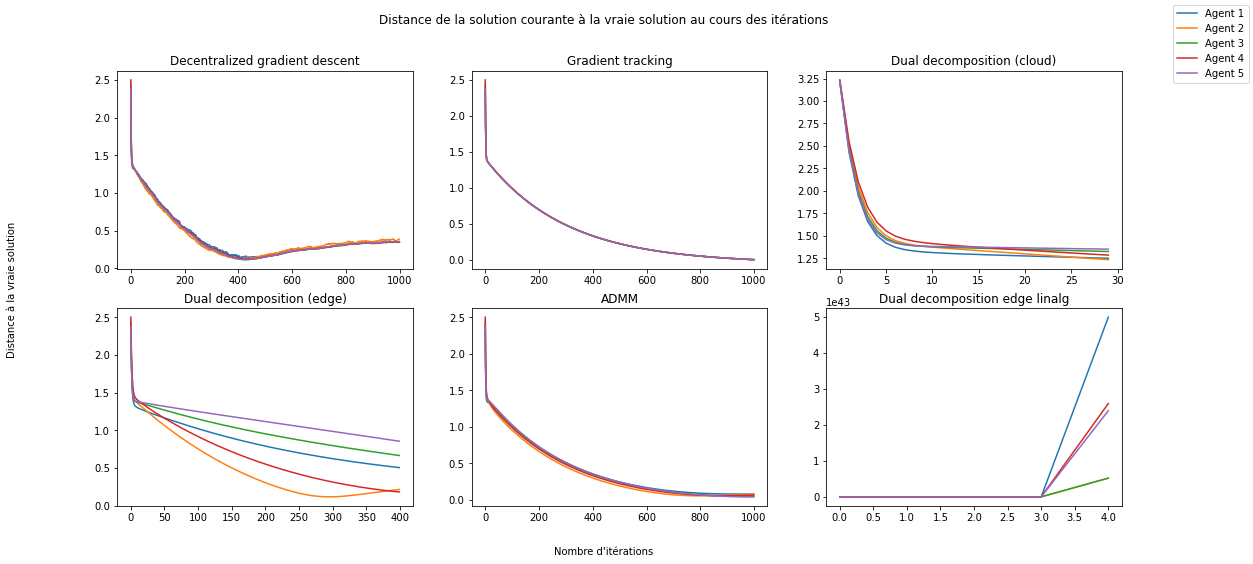

In [199]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

axs[0,0].plot(solver_DGD.distance_to_optimum)
axs[0,0].set_title("Decentralized gradient descent")
axs[0,1].plot(solver_gradient_tracking.distance_to_optimum)
axs[0,1].set_title("Gradient tracking")
axs[0,2].plot(solver_dual_decomposition.distance_to_optimum)
axs[0,2].set_title("Dual decomposition (cloud)")
axs[1,0].plot(solver_dual_decomposition_edge.distance_to_optimum)
axs[1,0].set_title("Dual decomposition (edge)")
axs[1,1].plot(solver_ADMM.distance_to_optimum)
axs[1,1].set_title("ADMM")
axs[1,2].plot(solver_dual_decomposition_edge_linalg.distance_to_optimum)
axs[1,2].set_title("Dual decomposition edge linalg")
fig.text(0.5, 0.04, "Nombre d'itérations", ha='center')
fig.text(0.04, 0.5, "Distance à la vraie solution", va='center', rotation='vertical')

fig.suptitle("Distance de la solution courante à la vraie solution au cours des itérations")
fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()


### Visualisation de la fonction obtenue

In [165]:
def f(alpha,centers_kernel,x):
    number_of_kernels = np.shape(centers_kernel)[0]
    kernels = np.array([kernel(x,centers_kernel[i]) for i in range(number_of_kernels)])
    return(np.dot(alpha,kernels))

In [166]:
t = np.linspace(-1,1,250)

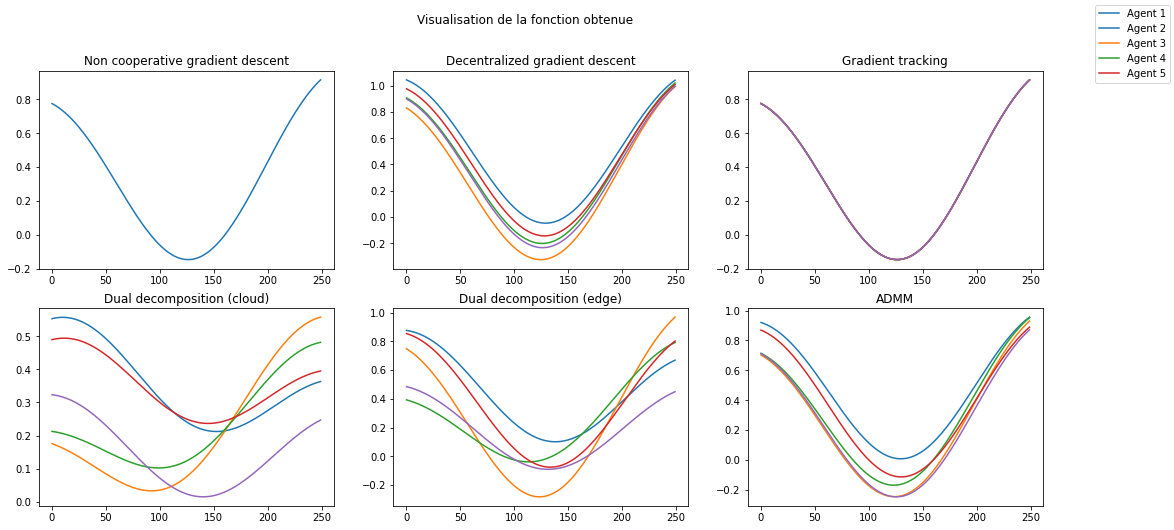

In [123]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

estimee_gradient_descent = np.array([f(solver_non_cooperative.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[0,0].plot(estimee_gradient_descent)
axs[0,0].set_title("Non cooperative gradient descent")
estimee_DGD = np.array([f(solver_DGD.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[0,1].plot(estimee_DGD)
axs[0,1].set_title("Decentralized gradient descent")
estimee_gradient_tracking = np.array([f(solver_gradient_tracking.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[0,2].plot(estimee_gradient_tracking)
axs[0,2].set_title("Gradient tracking")
estimee_dual= np.array([f(solver_dual_decomposition.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
axs[1,0].plot(estimee_dual)
axs[1,0].set_title("Dual decomposition (cloud)")
estimee_dual_cloud = np.array([f(solver_dual_decomposition_edge.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
axs[1,1].plot(estimee_dual_cloud)
axs[1,1].set_title("Dual decomposition (edge)")
estimee_ADMM = np.array([f(solver_ADMM.curent_solution,centers_kernel,t[i])for i in range(250)])
axs[1,2].plot(estimee_ADMM)
axs[1,2].set_title("ADMM")
fig.suptitle("Visualisation de la fonction obtenue")
fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()

### Tracés pour d'autre structures de graphe

In [173]:
def train_all_models(communication_matrix,package_loss,probability_package_loss):
    instance_pb = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,communication_matrix,0.5)
    #computing the "true_solution"
    solver_non_cooperative = gradient_descent(instance_pb,0.0001,2000,np.ones(10))
    true_solution = solver_non_cooperative.solve(verbose=False)
    instance_pb.true_solution =  true_solution
    #DGD & gradient tracking
    solver_DGD = DGD(instance_pb,0.001,1000,np.ones(10))
    solver_DGD.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    solver_gradient_tracking = gradient_tracking(instance_pb,0.0001,1000,np.ones(10))
    solver_gradient_tracking.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    #Dual decompo (edge & cloud) & ADMM
    solver_dual_decomposition = dual_decomposition(instance_pb,0.0001,0.0001,10,300,np.ones(10),np.ones(50))
    solver_dual_decomposition.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    solver_dual_decomposition_edge = dual_decomposition_edge(instance_pb,0.001,0.001,1,4000,np.ones(10),np.ones(10))
    solver_dual_decomposition_edge.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    solver_ADMM = ADMM(instance_pb,0.001,1000,np.ones(10),np.ones(10),50)
    solver_ADMM.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    solver_dual_decomposition_edge_linalg = dual_decomposition_edge_linalg(instance_pb,0.001,0.001,1,4000,np.ones(10),np.ones(10))
    solver_dual_decomposition_edge_linalg.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    #ploting convergence
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

    axs[0,0].plot(solver_DGD.distance_to_optimum)
    axs[0,0].set_title("Decentralized gradient descent")
    axs[0,1].plot(solver_gradient_tracking.distance_to_optimum)
    axs[0,1].set_title("Gradient tracking")
    axs[0,2].plot(solver_dual_decomposition.distance_to_optimum)
    axs[0,2].set_title("Dual decomposition (cloud)")
    axs[1,0].plot(solver_dual_decomposition_edge.distance_to_optimum)
    axs[1,0].set_title("Dual decomposition (edge)")
    axs[1,1].plot(solver_ADMM.distance_to_optimum)
    axs[1,1].set_title("ADMM")
    axs[1,2].plot(solver_dual_decomposition_edge_linalg.distance_to_optimum)
    axs[1,2].set_title("dual decomposition edge linalg")
    fig.text(0.5, 0.04, "Nombre d'itérations", ha='center')
    fig.text(0.04, 0.5, "Distance à la vraie solution", va='center', rotation='vertical')

    fig.suptitle("Distance de la solution courante à la vraie solution au cours des itérations")
    fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
    plt.show()
    
    #ploting the obtained function
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

    estimee_DGD = np.array([f(solver_DGD.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,0].plot(estimee_DGD)
    axs[0,0].set_title("DGD")

    estimee_gradient_tracking = np.array([f(solver_gradient_tracking.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,1].plot(estimee_gradient_tracking)
    axs[0,1].set_title("Gradient tracking")
    estimee_dual= np.array([f(solver_dual_decomposition.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,2].plot(estimee_dual)
    axs[0,2].set_title("Dual decomposition (cloud)")
    estimee_dual_cloud = np.array([f(solver_dual_decomposition_edge.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,0].plot(estimee_dual_cloud)
    axs[1,0].set_title("Dual decomposition (edge)")
    estimee_ADMM = np.array([f(solver_ADMM.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,1].plot(estimee_ADMM)
    axs[1,1].set_title("ADMM")
    estimee_dual_linalg = np.array([f(solver_dual_decomposition_edge_linalg.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,2].plot(estimee_dual_linalg)
    axs[1,2].set_title("dual decomposition edge linalg")
    fig.suptitle("Visualisation de la fonction obtenue")
    fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
    plt.show()

    

**Fully connected**

In [174]:
train_all_models(A1,False,0)

AttributeError: 'instance' object has no attribute 'matrix_Knm'

**Fully connected** package loss probability = 0.3

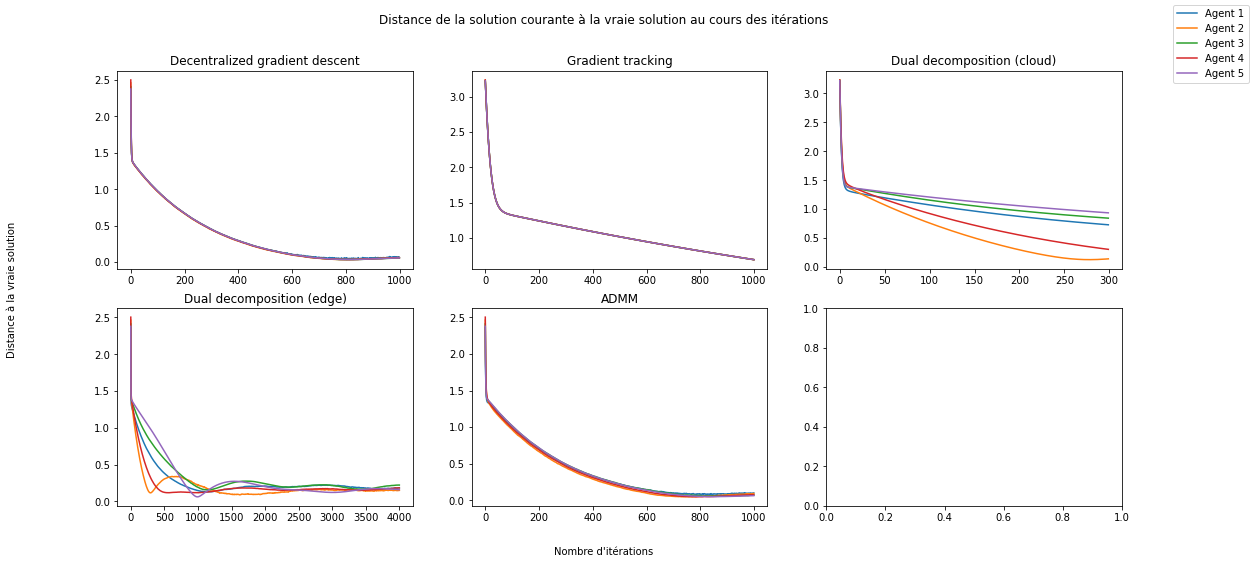

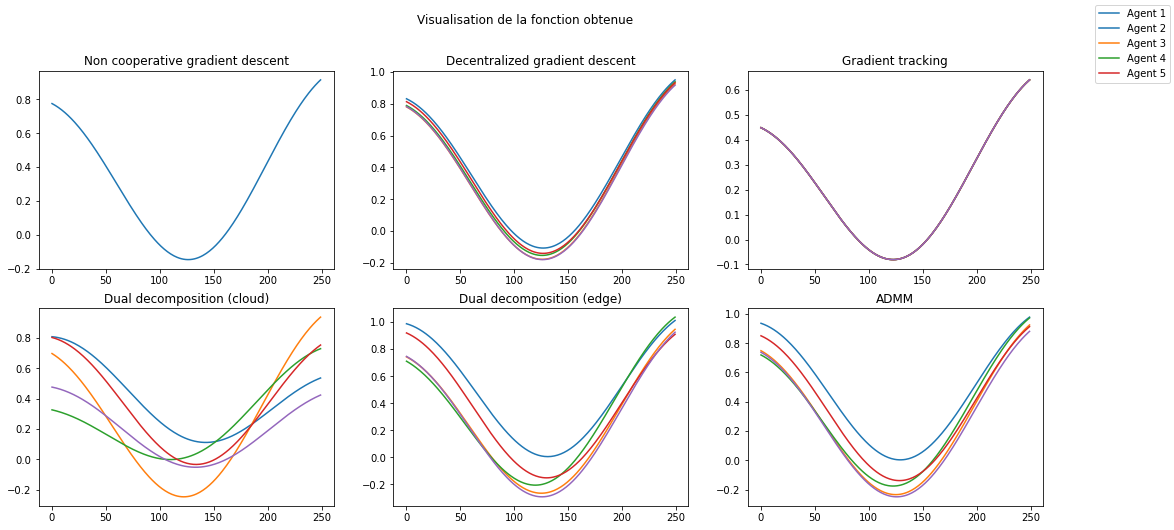

In [135]:
train_all_models(A1,True,0.3)

**Fully connected** package loss probability = 0.6

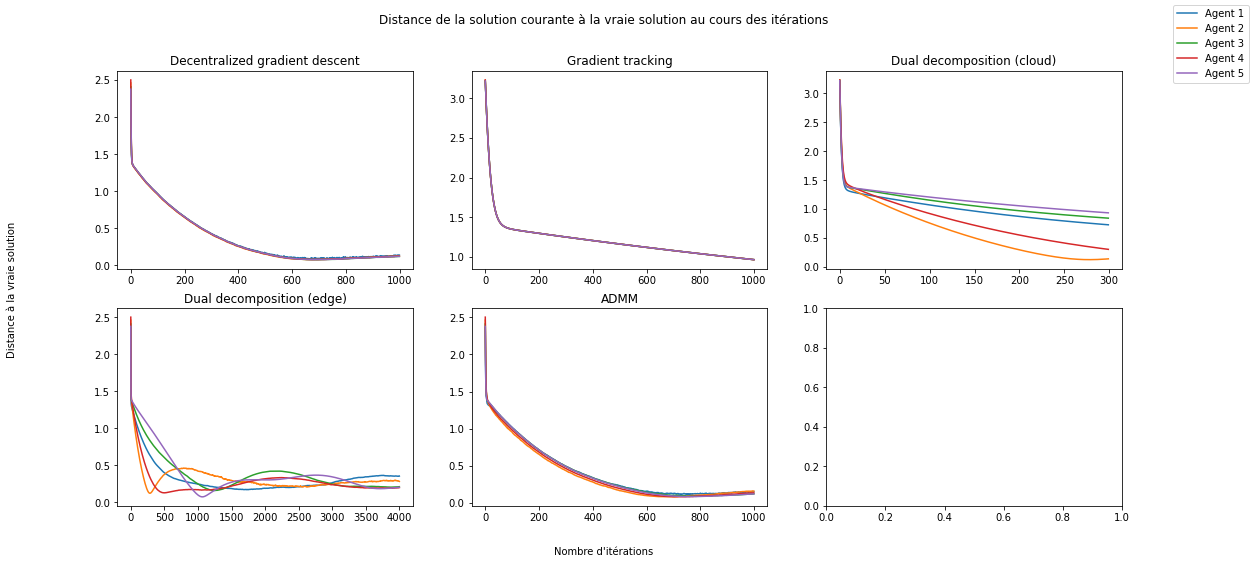

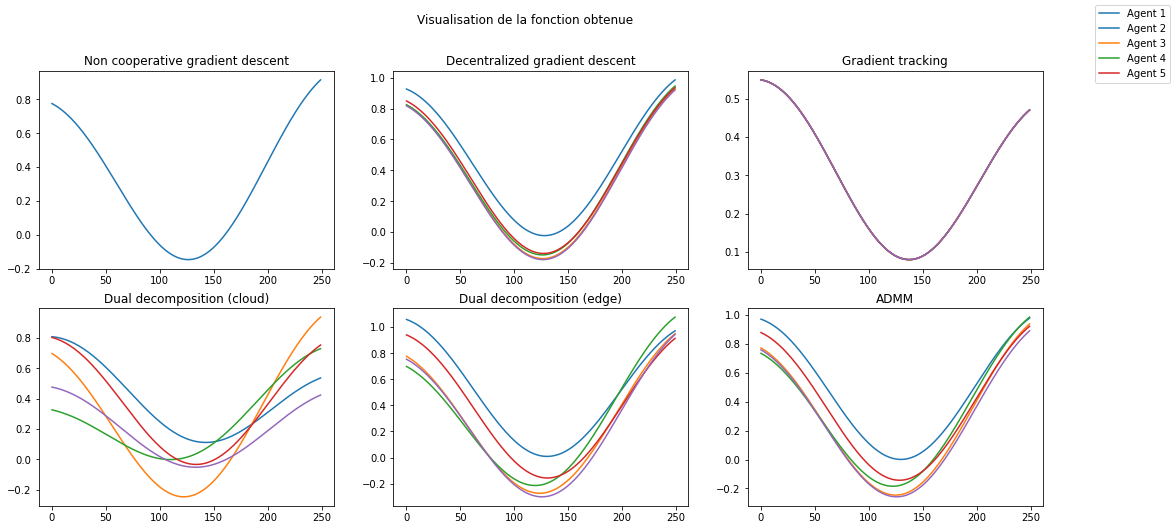

In [136]:
train_all_models(A1,True,0.6)

**Small world**

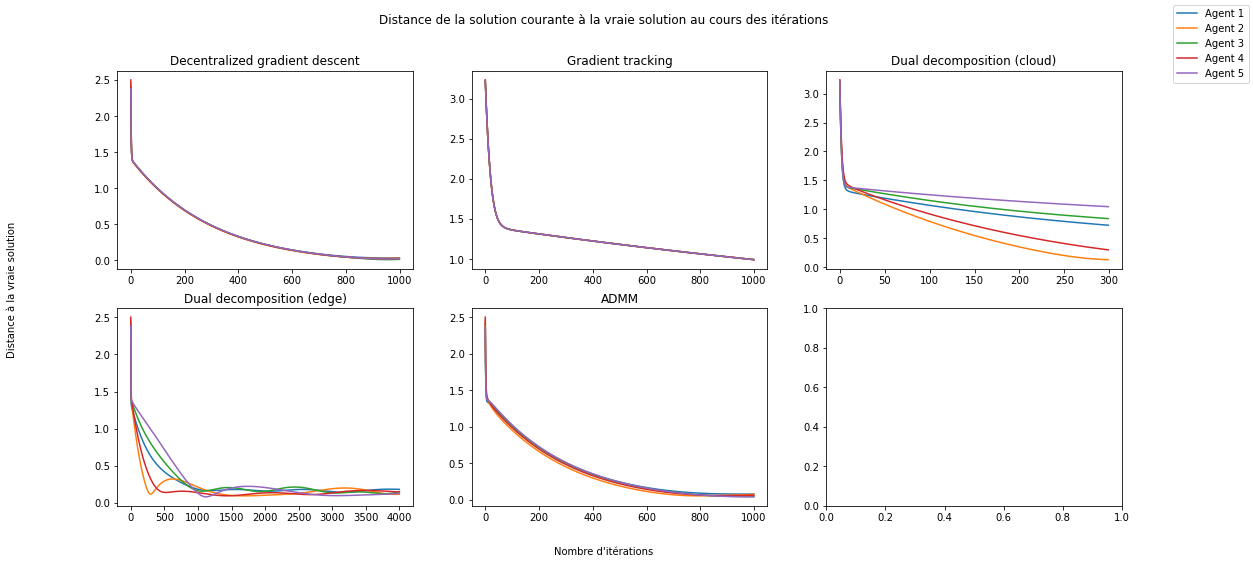

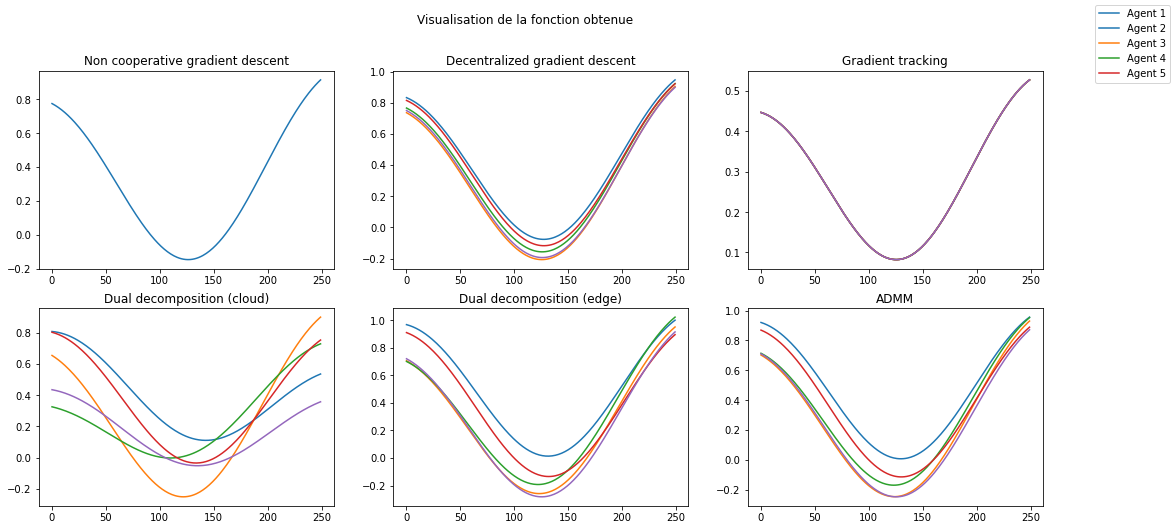

In [137]:
train_all_models(A2,False,0)

**Cycle**

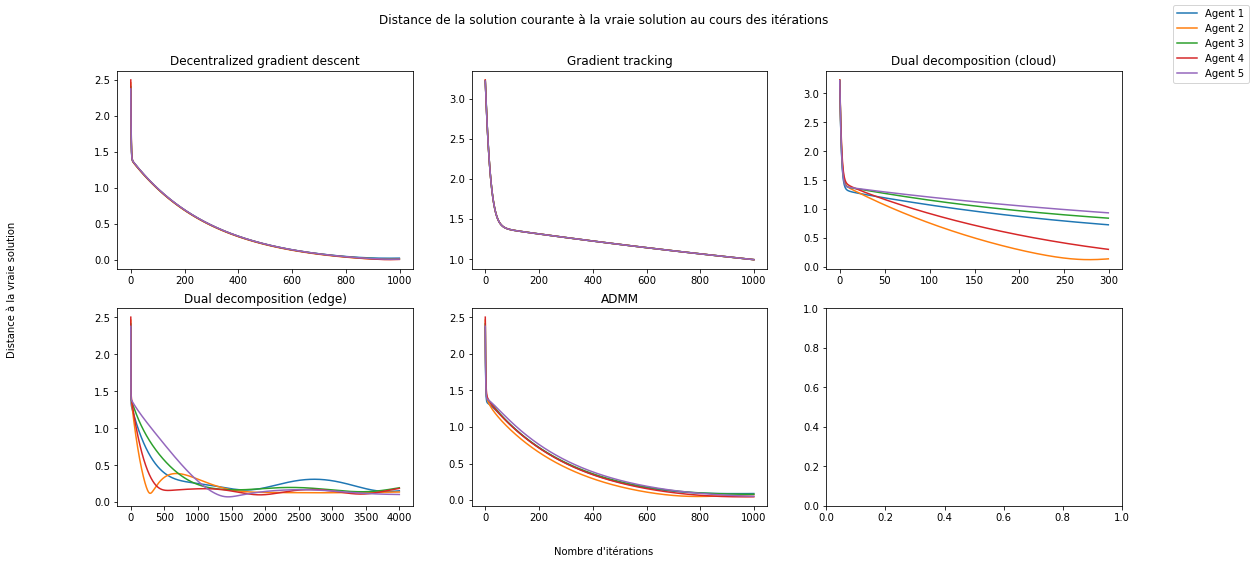

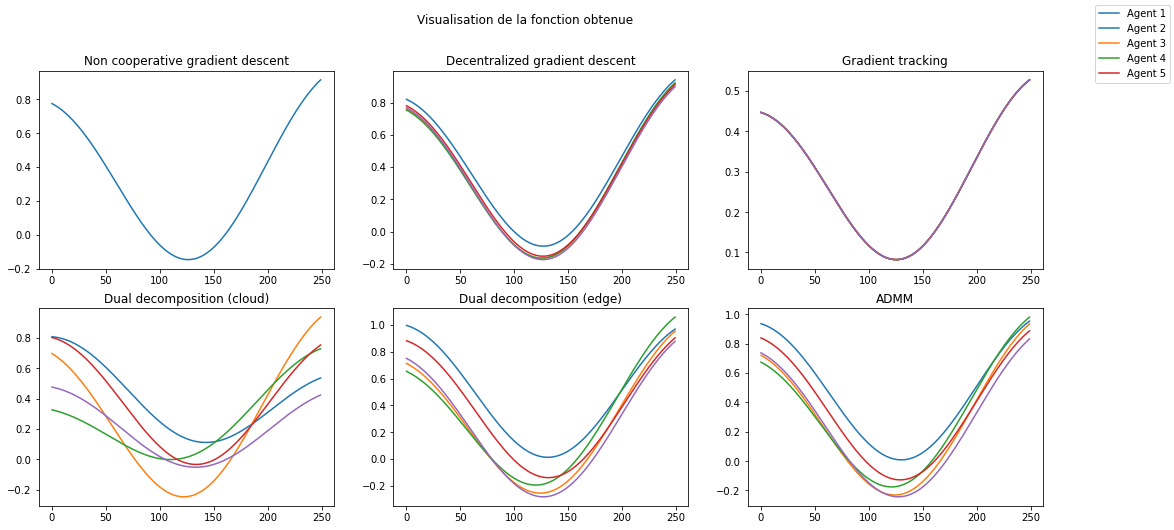

In [138]:
train_all_models(A3,False,0)

**Line**

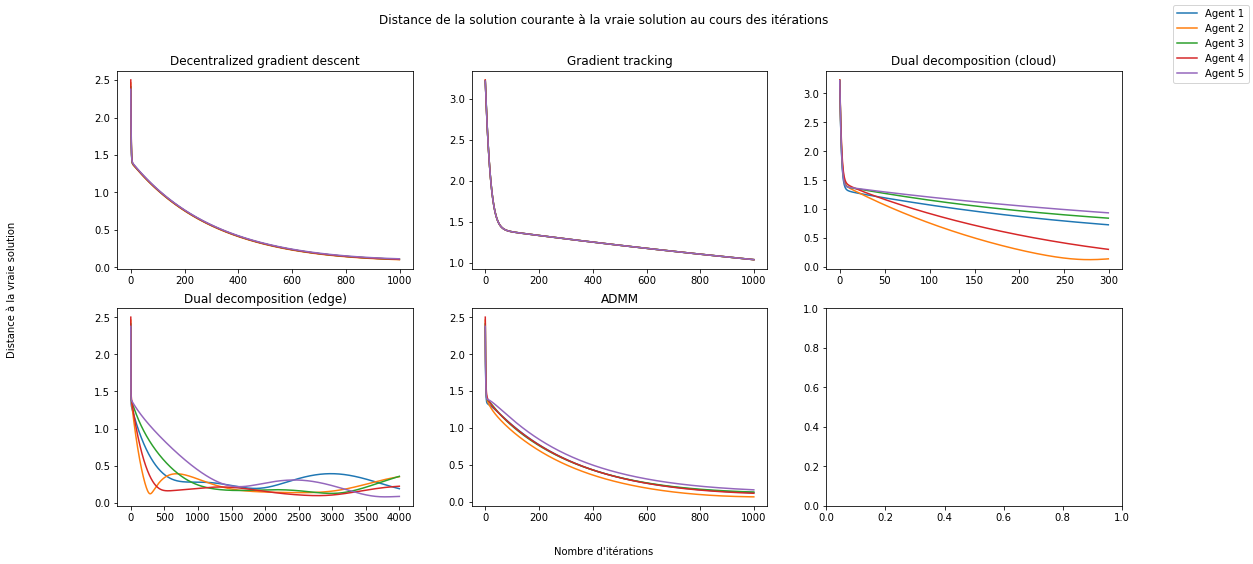

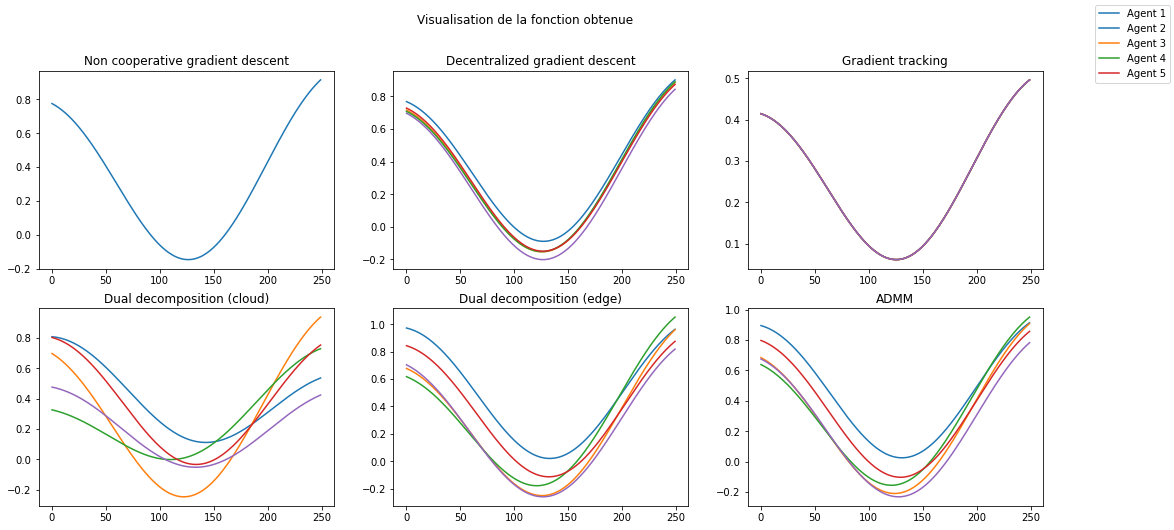

In [139]:
train_all_models(A4,False,0)

**Non connex**

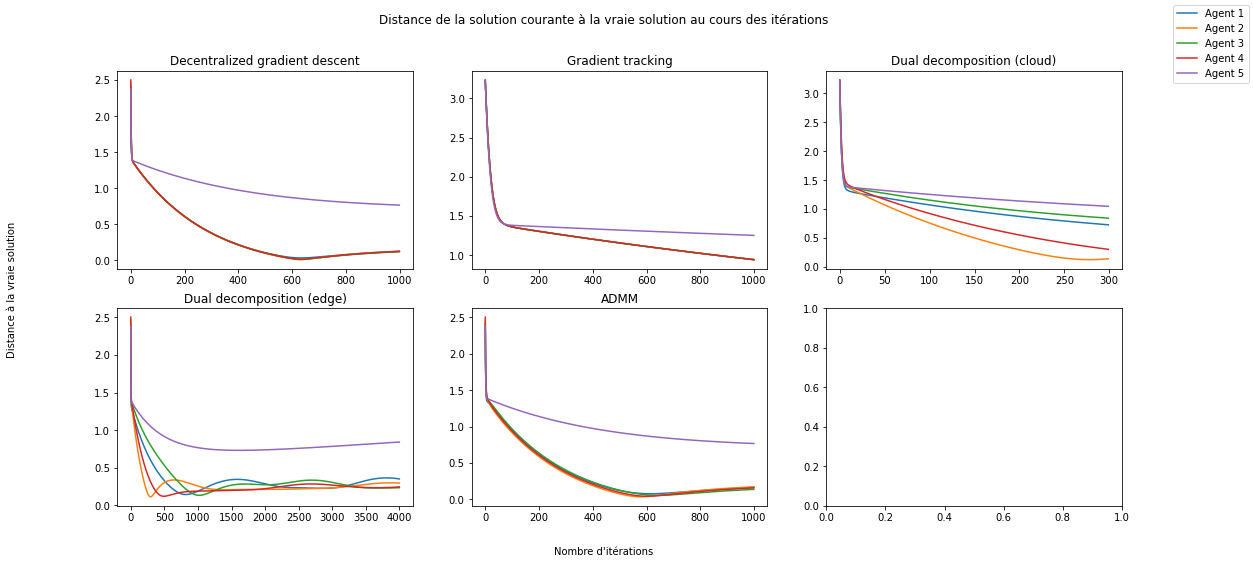

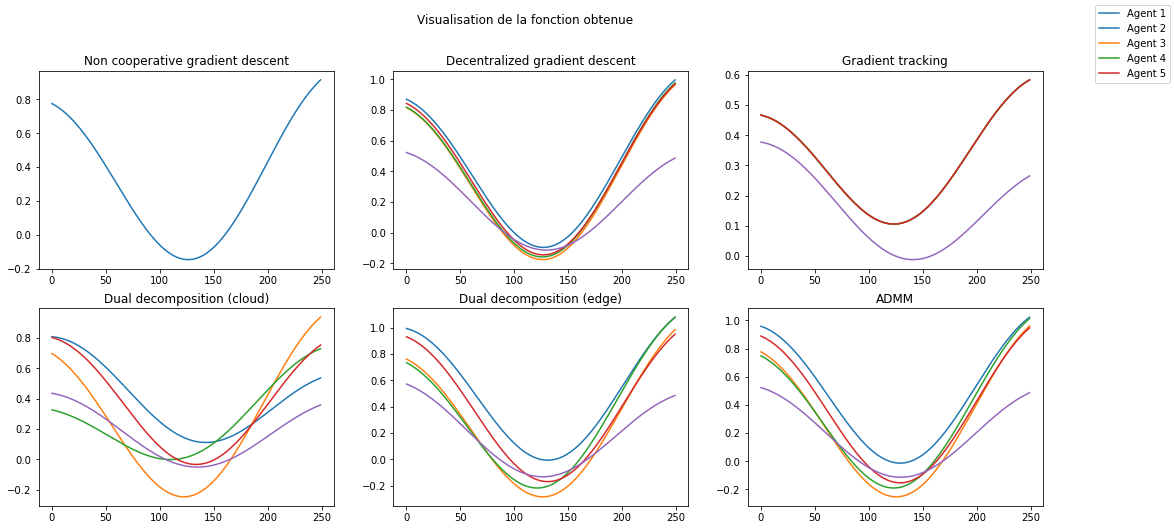

In [140]:
train_all_models(A5,False,0)